In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib notebook

In [76]:
import qcodes
qc = qcodes

from pysweep import measurement
from pysweep import sweep, Measurement
from pysweep import data_plot

In [17]:
from qctools import instruments as instools

In [15]:
%run init_vars.py

In [49]:
%run init_instruments.py

ivvi.dac1.set_delay(0.001)
ivvi.dac1.set_step(20)
ivvi.dac6.set_delay(0.001)
ivvi.dac6.set_step(5)
ivvi.dac8.set_delay(0.001)
ivvi.dac8.set_step(5)
ivvi.dac12.set_delay(0.001)
ivvi.dac12.set_step(5)
ivvi.dac4.set_delay(0.001)
ivvi.dac4.set_step(5)

Instrument ivvi already exists.
Instrument sr1 already exists.
Instrument key1 already exists.
Instrument RF already exists.
Instrument LO already exists.
Instrument alazar already exists.
Instrument fg already exists.


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [50]:
station = qcodes.Station(key, ivvi, sr1, RF, LO, alazar, fg)
Measurement.set_station(station)

C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:616: UserWarning: set_validator is deprected use `inst.vals = MyValidator` instead
  "set_validator is deprected use `inst.vals = MyValidator` instead")


In [99]:
from experiment import measurement
reload(measurement)
from experiment.measurement import Parameter, BaseMeasurement

In [100]:
from qcodes.instrument_drivers.AlazarTech.acq_controllers import ATS9360Controller
from qcodes.instrument_drivers.AlazarTech.acq_controllers.\
    alazar_channel import AlazarChannel

class AlazarMeasurement(BaseMeasurement):
    
    controller_cls = ATS9360Controller
    ats_nchans = 2
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.add_parameter('ats_int_time', Parameter, initial_value=1e-6)
        self.add_parameter('ats_int_delay', Parameter, initial_value=2e-7)
        self.add_parameter('ats_demod', Parameter, initial_value=False)
        self.add_parameter('ats_integrate_samples', Parameter, initial_value=False)
        self.add_parameter('ats_average_records', Parameter, initial_value=False)
        self.add_parameter('ats_average_buffers', Parameter, initial_value=True)
        self.add_parameter('ats_records_per_buffer', Parameter, initial_value=1)

        self.add_parameter('IF', Parameter, initial_value=1e6)
        self.add_parameter('navgs', Parameter, initial_value=1)
        
        self.samples_per_record = None

        
    def _setup_channels(self, **kw):
        self.chans = []
        for c in ['A', 'B']:
            _chan = AlazarChannel(self.station.alazar_ctl,
                                  'chan'+c, 
                                  demod=self.ats_demod(),
                                  integrate_samples=self.ats_integrate_samples(),
                                  average_records=self.ats_average_records(),
                                  average_buffers=self.ats_average_buffers())
            self.station.alazar_ctl.channels.append(_chan)
            self.chans.append(_chan)
            
            if self.ats_demod():
                _chan.demod_freq(self.IF())
                _chan.demod_type('IQ')
        
        self.station.alazar_ctl.int_time(self.ats_int_time())
        self.station.alazar_ctl.int_delay(self.ats_int_delay())
        self.samples_per_record = self.station.alazar_ctl.samples_per_record()
        
        
        for c, n in zip(self.chans, ['A', 'B']):
            c.num_averages(self.navgs())
            if not self.ats_average_records():
                c.records_per_buffer(self.ats_records_per_buffer())
            c.alazar_channel(n)
            c.prepare_channel()
            
    
    def setup_alazar(self, **kw):
        if hasattr(self.station, 'alazar_ctl'):
            del station.components['alazar_ctl']

        _ctl = instools.create_inst(self.controller_cls, 'alazar_ctl',
                                    alazar_name='alazar', filter='ave', 
                                    force_new_instance=True)
        self.station.add_component(_ctl)
        self.station.alazar.config(**self.namespace.ats_settings)
        self._setup_channels()

    def acquire(self):
        return self.station.alazar_ctl.channels.data()
    

    
class AlzTimeTrace(AlazarMeasurement):
    
    def measure(self):
        self.setup_alazar()
        
        A, B = self.acquire()
        tvals = np.arange(A.size) / float(self.station.alazar.sample_rate()) * 1e6
        
        dset = OrderedDict(
            {
                'time' : {'value' : tvals, 'unit' : 'us', 'independent_parameter': True},
                'A' : {'value' : A, 'unit' : 'V'},
                'B' : {'value' : B, 'unit' : 'V'},
            }
        )
        
        self.data.add(dset)
        

In [105]:
namespace.ats_settings['sample_rate'] = 1e9

m = AlzTimeTrace(station, namespace)
m.run()
%notebook -e {m.metadata_prefix}.nb

Instrument alazar_ctl already exists.


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:1097: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


In [75]:
m.data['A [V]']

In [51]:
alazar.sample_rate()

1000000000

<IPython.core.display.Javascript object>


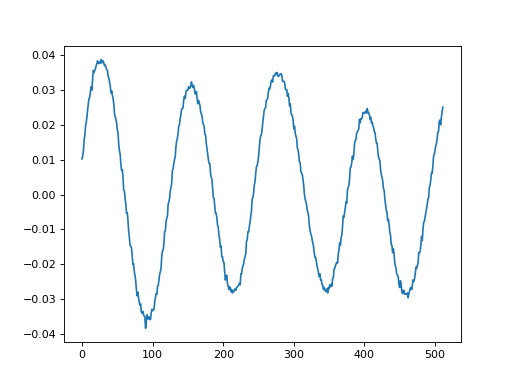

In [46]:
fig, ax = plt.subplots(1,1)
ax.plot(A)